In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [2]:
try:
    data = pd.read_csv("dataset1.csv")
except FileNotFoundError:
    print("Error: 'dataset1.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# Display basic information about the dataset
print("First 5 rows of the dataset:")
print(data.head())
print("\nDataset Information:")
data.info()
print("\nDescriptive Statistics:")
print(data.describe())
print("\nMissing values per column:")
print(data.isnull().sum())

# Handle potential missing values
for column in data.columns:
    if data[column].isnull().any():
        if pd.api.types.is_numeric_dtype(data[column]):
            print(f"Filling missing values in numeric column '{column}' with its mean.")
            data[column] = data[column].fillna(data[column].mean())
        else: 
            print(f"Filling missing values in categorical column '{column}' with its mode.")
            data[column] = data[column].fillna(data[column].mode()[0])


First 5 rows of the dataset:
     N    P    K    pH    EC    OC     S    Zn    Fe    Cu    Mn     B  Output
0  138  8.6  560  7.46  0.62  0.70   5.9  0.24  0.31  0.77  8.71  0.11       0
1  213  7.5  338  7.62  0.75  1.06  25.4  0.30  0.86  1.54  2.89  2.29       0
2  163  9.6  718  7.59  0.51  1.11  14.3  0.30  0.86  1.57  2.70  2.03       0
3  157  6.8  475  7.64  0.58  0.94  26.0  0.34  0.54  1.53  2.65  1.82       0
4  270  9.9  444  7.63  0.40  0.86  11.8  0.25  0.76  1.69  2.43  2.26       1

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       880 non-null    int64  
 1   P       880 non-null    float64
 2   K       880 non-null    int64  
 3   pH      880 non-null    float64
 4   EC      880 non-null    float64
 5   OC      880 non-null    float64
 6   S       880 non-null    float64
 7   Zn      880 non-null    float64


In [3]:
if "Output" not in data.columns:
    print("Error: 'Output' column not found in the dataset. Please specify the correct target column.")
    exit()

X = data.drop("Output", axis=1)
y = data["Output"]

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

print(f"\nOriginal unique classes in 'Output': {np.unique(y)}")
print(f"Encoded unique classes in 'Output': {np.unique(y_encoded)}")
print(f"Number of unique classes: {num_classes}")

if num_classes <= 1:
    print("Error: The target variable 'Output' has only one class or is not suitable for classification after encoding.")
    exit()



Original unique classes in 'Output': [0 1 2]
Encoded unique classes in 'Output': [0 1 2]
Number of unique classes: 3


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded if num_classes > 1 else None
)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (704, 12)
Shape of X_test: (176, 12)
Shape of y_train: (704,)
Shape of y_test: (176,)


In [5]:
numerical_cols = X_train.select_dtypes(include=np.number).columns
non_numerical_cols = X_train.select_dtypes(exclude=np.number).columns

if len(non_numerical_cols) > 0:
    print(f"Warning: Non-numerical columns found in features: {list(non_numerical_cols)}. These will not be scaled by StandardScaler.")
    # Future step: Add one-hot encoding or other appropriate preprocessing for these non_numerical_cols if they exist

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

if len(numerical_cols) > 0:
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])
else:
    print("No numerical columns found to scale.")

In [6]:
model = Sequential(name="Soil_Fertility_Prediction_Model")
model.add(Input(shape=(X_train_scaled.shape[1],), name="Input_Layer"))
model.add(Dense(units=128, activation='relu', kernel_initializer='he_normal', name="Hidden_Layer_1"))
model.add(Dropout(0.4, name="Dropout_1"))
model.add(Dense(units=64, activation='relu', kernel_initializer='he_normal', name="Hidden_Layer_2"))
model.add(Dropout(0.3, name="Dropout_2"))
model.add(Dense(units=32, activation='relu', kernel_initializer='he_normal', name="Hidden_Layer_3"))
model.add(Dense(units=num_classes, activation='softmax', name="Output_Layer"))

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "Soil_Fertility_Prediction_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, 128)               1664      
                                                                 
 Dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 Hidden_Layer_2 (Dense)      (None, 64)                8256      
                                                                 
 Dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 Hidden_Layer_3 (Dense)      (None, 32)                2080      
                                                                 
 Output_Layer (Dense)        (None, 3)                 99        
                                                                 
Total params: 12099 (47.26 KB)
Trai

In [8]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=8,
    min_lr=0.00001,
    verbose=1
)

In [9]:
# Train the model
print("\nStarting model training...")
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Starting model training...
Epoch 1/200


22/22 [==============================] - 2s 12ms/step - loss: 2.3292 - accuracy: 0.3182 - val_loss: 1.1964 - val_accuracy: 0.3466 - lr: 5.0000e-04
Epoch 2/200
22/22 [==============================] - 0s 3ms/step - loss: 1.2476 - accuracy: 0.4588 - val_loss: 0.9314 - val_accuracy: 0.5909 - lr: 5.0000e-04
Epoch 3/200
22/22 [==============================] - 0s 3ms/step - loss: 1.0546 - accuracy: 0.5355 - val_loss: 0.8249 - val_accuracy: 0.6250 - lr: 5.0000e-04
Epoch 4/200
22/22 [==============================] - 0s 3ms/step - loss: 0.8579 - accuracy: 0.6179 - val_loss: 0.7461 - val_accuracy: 0.6989 - lr: 5.0000e-04
Epoch 5/200
22/22 [==============================] - 0s 3ms/step - loss: 0.7959 - accuracy: 0.6605 - val_loss: 0.6824 - val_accuracy: 0.7670 - lr: 5.0000e-04
Epoch 6/200
22/22 [==============================] - 0s 3ms/step - loss: 0.7483 - accuracy: 0.7116 - val_loss: 0.6374 - val_accuracy: 0.7670 - lr: 5.0000e-04
Epoch 7/200
22/22 [==

In [10]:
# Evaluate the model on the test set
print("\nEvaluating model on the test set...")
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Evaluating model on the test set...

Test Loss: 0.4132
Test Accuracy: 86.93%


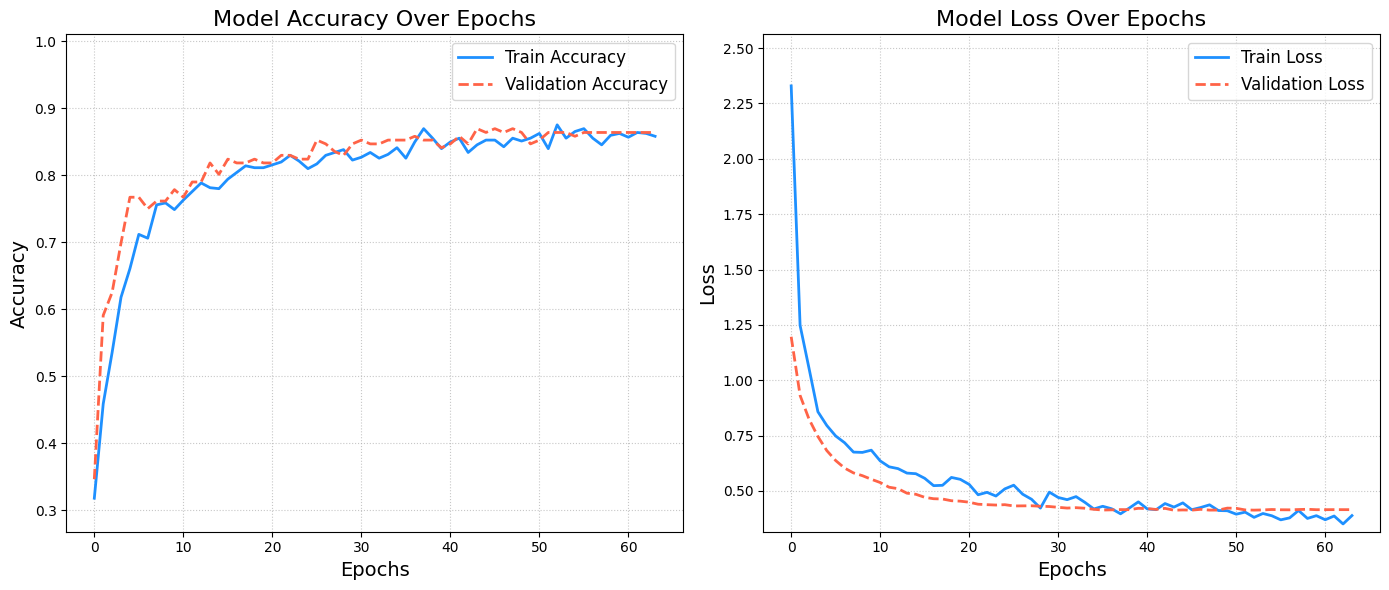

In [11]:
# Plot training history
def plot_history(history_obj):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history_obj.history['accuracy'], label='Train Accuracy', color='dodgerblue', linewidth=2)
    plt.plot(history_obj.history['val_accuracy'], label='Validation Accuracy', color='tomato', linestyle='--', linewidth=2)
    plt.title('Model Accuracy Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.7)
    min_acc = 0
    if 'accuracy' in history_obj.history and 'val_accuracy' in history_obj.history:
        if history_obj.history['accuracy'] and history_obj.history['val_accuracy']: # Check if lists are not empty
             min_acc = min(min(history_obj.history['accuracy']), min(history_obj.history['val_accuracy']))
    plt.ylim([max(0, min_acc - 0.05), 1.01])


    plt.subplot(1, 2, 2)
    plt.plot(history_obj.history['loss'], label='Train Loss', color='dodgerblue', linewidth=2)
    plt.plot(history_obj.history['val_loss'], label='Validation Loss', color='tomato', linestyle='--', linewidth=2)
    plt.title('Model Loss Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.7)
    max_loss_val = 1.0 # Default max
    min_loss_val = 0.0 # Default min
    if 'loss' in history_obj.history and 'val_loss' in history_obj.history:
        if history_obj.history['loss'] and history_obj.history['val_loss']: # Check if lists are not empty
            max_loss_val = max(max(history_obj.history['loss']), max(history_obj.history['val_loss']))
            min_loss_val = min(min(history_obj.history['loss']), min(history_obj.history['val_loss']))
    plt.ylim([max(0, min_loss_val - 0.1*abs(min_loss_val)) , min(max_loss_val * 1.1, max_loss_val + 0.5)])


    plt.tight_layout()
    plt.show()

plot_history(history)

In [12]:
# 1. Save the Keras model
model.save("soil_fertility_model.h5") # Saves the model architecture, weights, and training configuration
print("Keras model saved as soil_fertility_model.h5")

# 2. Save the StandardScaler
import joblib
joblib.dump(scaler, "scaler.joblib")
print("Scaler saved as scaler.joblib")

# 3. Save the LabelEncoder (important if you need to interpret class labels later)
joblib.dump(label_encoder, "label_encoder.joblib")
print("LabelEncoder saved as label_encoder.joblib")

Keras model saved as soil_fertility_model.h5
Scaler saved as scaler.joblib
LabelEncoder saved as label_encoder.joblib


c:\Users\Brijesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
